In [1]:
import pickle
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
from matplotlib import colors
import torch

import composlang

In [2]:
!ls -hlt

total 6.9G
-rw-r--r-- 1 asathe evlab 853K Jan 22 23:44 figure-1-analyze-simulated.ipynb
-rw-r--r-- 1 asathe evlab  88M Jan 19 13:15 pair_freq.pkl
-rw-r--r-- 1 asathe evlab 6.2M Jan 19 12:12 noun_freqs.pkl
-rw-r--r-- 1 asathe evlab 2.2M Jan 19 12:12 adj_freqs.pkl
-rw-r--r-- 1 asathe evlab  23K Jan 17 01:49 stimuli_for_LMs.ipynb
-rw-r--r-- 1 asathe evlab 790K Jan 17 01:48 beh_stims_9907.csv
-rw-r--r-- 1 asathe evlab  30M Jan 16 23:18 an_stims_for_LM_eval.csv
-rw-r--r-- 1 asathe evlab 229M Oct 18  2022 mat_simulated.pkl
-rw-r--r-- 1 asathe evlab 302M Oct 18  2022 pair_df_simulated.pkl
-rw-rw-r-- 1 asathe evlab 1.1G Oct 18  2022 combs.pkl
-rw-rw-r-- 1 asathe evlab 5.0G Oct 17  2022 coca.pkl
-rw-rw-r-- 1 asathe evlab 249M Oct 17  2022 comp.pkl
-rw-rw-r-- 1 asathe evlab  42M Oct 13  2022 matrix.pkl


In [14]:
f"{len(comp_observed.child_df) :,}         {len(comp_observed.parent_df):,}"

'147,047         469,833'

In [11]:
f"{len(comp_observed.child_df) * len(comp_observed.parent_df):,}"

'69,087,533,151'

In [16]:
4423676 / 69087533151 * 100

0.006403001812688067

In [3]:
comp_observed = pd.read_pickle("./comp.pkl")
combs = pd.read_pickle("./combs.pkl")

In [4]:
mat_simulated = pd.read_pickle("./mat_simulated.pkl")
mat_observed = pd.read_pickle("./matrix.pkl")

In [5]:
pair_df_simulated = pd.DataFrame(
    [
        dict(
            child=(c := entry["child"]),
            parent=(p := entry["parent"]),
            pair=(c, p),
            freq=entry["pairfreq"],
        )
        for entry in tqdm(
            combs, desc="constructing a dataframe from simulated combinations"
        )
    ]
).sort_values("freq", ascending=False, ignore_index=True)

constructing a dataframe from simulated combinations:   0%|          | 0/25178311 [00:00<?, ?it/s]

[None, None, Text(0.5, 1.0, 'log-log frequency rank\nplot of Noun frequency')]

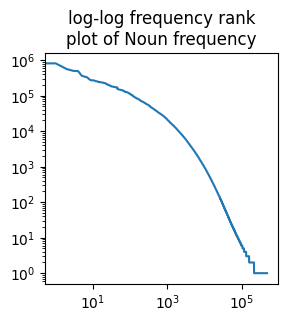

In [76]:
f, a = plt.subplots(figsize=(3, 3))
a.plot(comp_observed.parent_df.freq)
a.set(
    xscale="log", yscale="log", title="log-log frequency rank\nplot of Noun frequency"
)

In [19]:
comp_observed.pair_df

,child,parent,pair,freq
0,last,year,"(last, year)",63780
1,first,time,"(first, time)",48420
2,high,school,"(high, school)",44472
3,same,time,"(same, time)",35344
4,little,bit,"(little, bit)",33762
...,...,...,...,...
4423671,wet,electronics,"(wet, electronics)",1
4423672,top,contestant,"(top, contestant)",1
4423673,mellow,change,"(mellow, change)",1
4423674,colorful,sandstone,"(colorful, sandstone)",1


In [23]:
pair_freq = dict(
    zip(
        comp_observed.pair_df["pair"].apply(lambda p: " ".join(p)),
        comp_observed.pair_df["freq"],
    )
)

In [24]:
pd.to_pickle(pair_freq, "./pair_freq.pkl")

In [13]:
pair_df_simulated = pair_df_simulated.groupby(["pair"]).agg(
    {"child": "first", "parent": "first", "pair": "first", "freq": "count"}
)
pair_df_simulated.to_pickle("./pair_df_simulated.pkl")

In [65]:
pair_df_simulated = pd.read_pickle("./pair_df_simulated.pkl")

In [68]:
pair_df_simulated.sort_values(by="freq", ascending=False)

,child,parent,pair,freq
pair,,,,
"(other, time)",other,time,"(other, time)",4188
"(other, people)",other,people,"(other, people)",4126
"(more, people)",more,people,"(more, people)",3891
"(more, time)",more,time,"(more, time)",3725
"(other, years)",other,years,"(other, years)",2907
...,...,...,...,...
"(hispanic, preformatted)",hispanic,preformatted,"(hispanic, preformatted)",1
"(hispanic, predictors)",hispanic,predictors,"(hispanic, predictors)",1
"(hispanic, predicament)",hispanic,predicament,"(hispanic, predicament)",1


In [17]:
f"{len(pair_df_simulated):,}"  # b

'8,977,777'

In [18]:
f'{sum(pair_df_simulated["freq"]):,}'  # N

'25,178,311'

In [20]:
comp_simulated = pd.read_pickle("./comp.pkl")
comp_simulated.pair_df = pair_df_simulated

In [24]:
mat_simulated = comp_simulated.generate_adjacency_matrix(threshold=0)

constructing adjacency matrix:   0%|          | 0/8977777 [00:00<?, ?it/s]

In [25]:
with open("./mat_simulated.pkl", "wb") as f:
    pickle.dump(mat_simulated, f)

In [5]:
mat_simulated = pd.read_pickle("./mat_simulated.pkl")

In [30]:
def plot_matrix(mat, title=None, vmin=None, vmax=None, lognorm=True):
    f, ax = plt.subplots(figsize=(7, 7))
    im = ax.matshow(
        mat,
        aspect="auto",
        interpolation="none",
        origin="lower",
        cmap="Reds",
        norm=LogNorm(vmin=vmin, vmax=vmax) if lognorm else None,
    )

    f.colorbar(im)

    return f, ax

In [7]:
obs = mat_observed[:1000, :1000].todense()
sim = mat_simulated[:1000, :1000].todense()
max_value = max(
    max(obs.reshape(-1)),
    max(sim.reshape(-1)),
)
max_value

63780

In [8]:
obs_norm = obs / obs.sum()
sim_norm = sim / sim.sum()

(<Figure size 700x700 with 2 Axes>, <Axes: >)

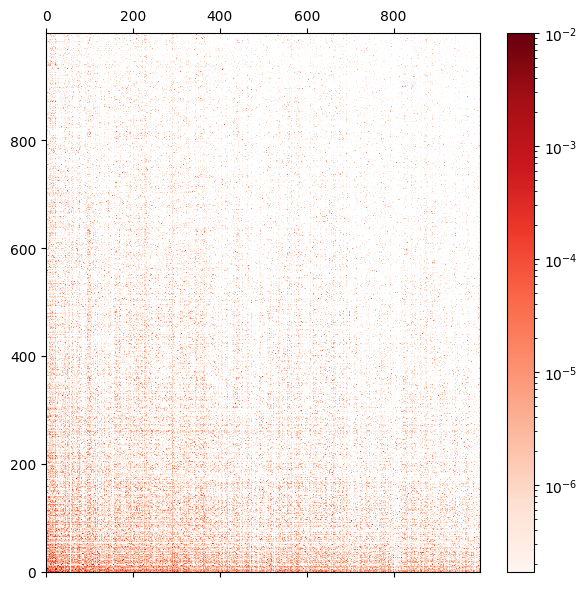

In [15]:
plot_matrix(obs_norm, vmax=10e-3)

(<Figure size 700x700 with 2 Axes>, <Axes: >)

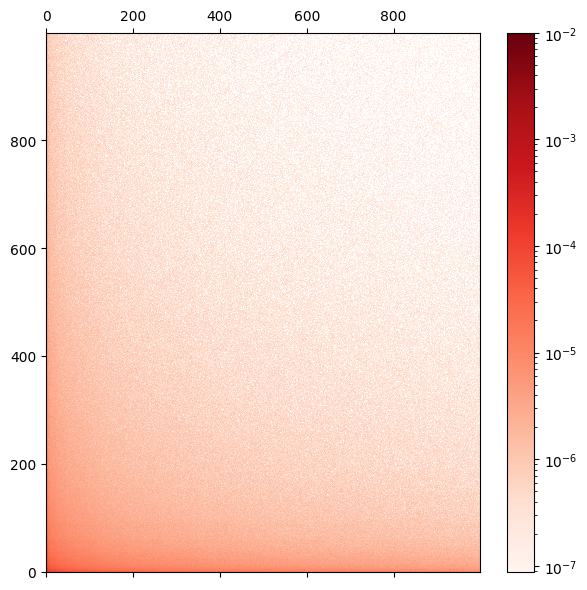

In [14]:
plot_matrix(sim_norm, vmax=10e-3)

In [40]:
mat_mpt30b = pd.read_pickle("./mat_mpt30b_bayes.pkl")
mat_mpt30b_norm = mat_mpt30b / mat_mpt30b.sum()

In [41]:
mat_mpt30b[:100, :100]

array([[ 22.58203125,  81.359375  ,  94.171875  , ..., 101.859375  ,
         81.359375  , 114.671875  ],
       [ 31.62597656,  59.53125   ,  71.4375    , ...,  95.25      ,
         71.4375    ,  99.21875   ],
       [ 59.34375   ,  74.8125    ,  72.5625    , ...,  74.8125    ,
         79.3125    ,  99.5625    ],
       ...,
       [ 94.5       , 112.21875   , 135.84375   , ..., 124.03125   ,
        112.21875   , 135.84375   ],
       [ 35.28710938,  85.17578125,  96.6484375 , ..., 130.0234375 ,
         96.6484375 ,  91.0859375 ],
       [ 58.6328125 ,  94.2578125 , 135.8203125 , ..., 118.0078125 ,
        100.1953125 , 112.0703125 ]])

(<Figure size 700x700 with 2 Axes>, <Axes: >)

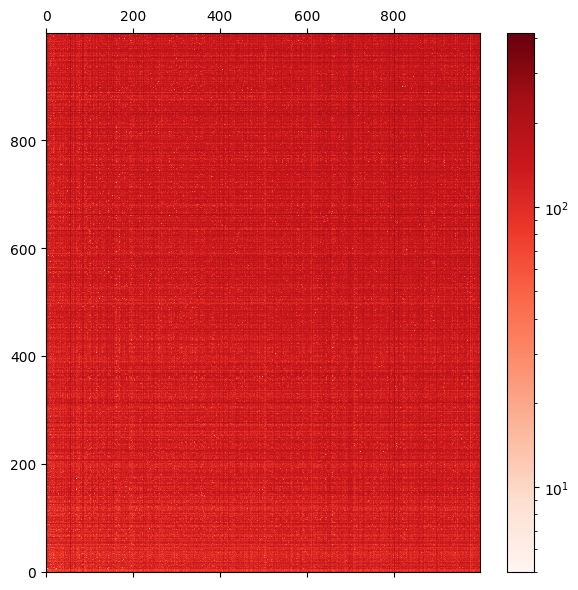

In [44]:
plot_matrix(
    mat_mpt30b[:1000, :1000],
)

In [72]:
diff = sim - obs

In [75]:
diff.max()

2887

In [ ]:
# define a diverging cmap with center at 0
cmap = sns.diverging_palette(220, 20, as_cmap=True)

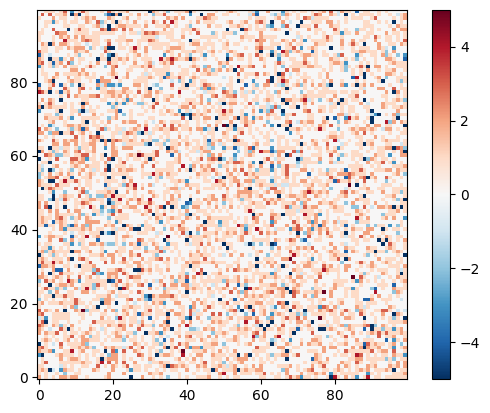

In [92]:
plt.imshow(
    (view := diff[-100:, -100:]),
    # norm=colors.TwoSlopeNorm(vmin=-diff.max(), vcenter=0, vmax=diff.max()),
    norm=colors.TwoSlopeNorm(vmin=-view.max(), vcenter=0, vmax=view.max()),
    cmap="RdBu_r",
    interpolation="none",
    origin="lower",
    # xlabel="noun",
    # ylabel="adjective",
)
plt.colorbar()

In [59]:
f"{sim.sum():,}", f"{obs.sum():,}"

('11,382,875', '11,763,491')

In [194]:
rows = []
for val in diff.reshape(-1):
    if val > 0:
        favor = "simulated"
    elif val < 0:
        favor = "observed"
    else:
        favor = "equal"
        continue
    rows += [
        {
            "diff": ((val)),
            "favor": favor,
        }
    ]
diff_df = pd.DataFrame(rows)  # .reset_index()
diff_df

,diff,favor
0,-16493,observed
1,2887,simulated
2,2616,simulated
3,2211,simulated
4,-5198,observed
...,...,...
902441,-4,observed
902442,1,simulated
902443,1,simulated
902444,1,simulated


In [195]:
diffs = diff_df["diff"].to_numpy()

In [214]:
(reshaped := diffs.reshape(2 * 653, 691))

array([[-62490, -46079, -43999, ...,  -1408,  -1404,  -1403],
       [ -1403,  -1399,  -1398, ...,   -817,   -816,   -816],
       [  -816,   -816,   -815, ...,   -592,   -592,   -591],
       ...,
       [   212,    212,    212, ...,    259,    259,    259],
       [   259,    259,    259, ...,    357,    357,    357],
       [   358,    358,    358, ...,   2450,   2616,   2887]])

In [238]:
plt.imshow(
    np.log(reshaped + abs(reshaped.min()) + 1),
    origin="lower",
    interpolation="none",
    cmap="coolwarm",
    aspect="equal",
    # norm=LogNorm(
    #     # vmin=0,
    #     # vmax=reshaped.max() + abs(reshaped.min()) + 1
    # ),
    norm=colors.TwoSlopeNorm(
        vmin=2,
        vcenter=np.log(abs(reshaped.min()) + 1),
        vmax=np.log(reshaped.max()),
    ),
)
plt.colorbar()

ValueError: vmin, vcenter, and vmax must be in ascending order

In [192]:
diff_df.groupby("favor").sum()

,diff
favor,
observed,8216714
simulated,7836098


In [275]:
obs[:100, :100]

array([[20619,  1301,   291, ...,    67,   294,    63],
       [ 8639, 11374,  3695, ...,    42,    11,   118],
       [ 1221,   179,    45, ...,   266,    67,    43],
       ...,
       [   14,    10,     3, ...,    23,     0,     0],
       [  373,   197,    72, ...,     4,    10,    79],
       [  135,   124,     2, ...,    20,     0,    24]])

In [188]:
obs_cumsum = np.cumsum(diff_df[diff_df["favor"] == "observed"]["diff"])
sim_cumsum = np.cumsum(diff_df[diff_df["favor"] == "simulated"]["diff"])

In [1]:
slc = slice(950, None)
g = sns.jointplot(
    x=sorted((view_obs := obs[slc, slc].reshape(-1)) + 1e-1),
    y=sorted((view_sim := sim[slc, slc].reshape(-1)) + 1e-1),
    kind="scatter",
    edgecolor=None,
    s=5,
    alpha=0.5,
    xlim=(1e-1, max(view_obs.max(), view_sim.max()) + 1),
    ylim=(1e-1, max(view_obs.max(), view_sim.max()) + 1),
)
g.plot_marginals(
    sns.rugplot,
    color="r",
    height=-0.05,
    clip_on=False,
)
g.plot_marginals(sns.kdeplot)
# plt.set_xlim(1, max_value + 1)
# plt.set_ylim(1, max_value + 1)
# g.ax_joint.set_xscale("log")
# g.ax_joint.set_yscale("log")
g.ax_joint.set_xlabel(
    "rank-ordered observed occurrences of\ncombinations of top 100 nouns and adjectives"
)
g.ax_joint.set_ylabel(
    "rank-ordered simulated (expected) occurrences of\ncombinations of top 100 nouns and adjectives\nusing a random sampling baseline"
)

plt.show()

NameError: name 'sns' is not defined